# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
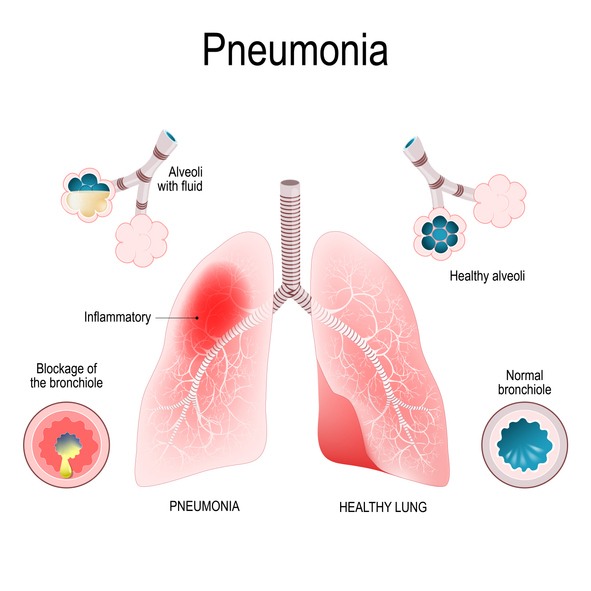

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import array_to_img, img_to_array

from tensorflow.keras.applications import ResNet50


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import Image, display

import matplotlib as mpl
import matplotlib.pyplot as plt

import keras

from skopt import BayesSearchCV

os.environ["KERAS_BACKEND"] = "tensorflow"

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

# Loading the Dataset

In [4]:
# TODO: add your own paths here
train = get_training_data('data/chest_xray/train')
test = get_training_data('data/chest_xray/test')
val = get_training_data('data/chest_xray/val')


# Data Visualization & Preprocessing

c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

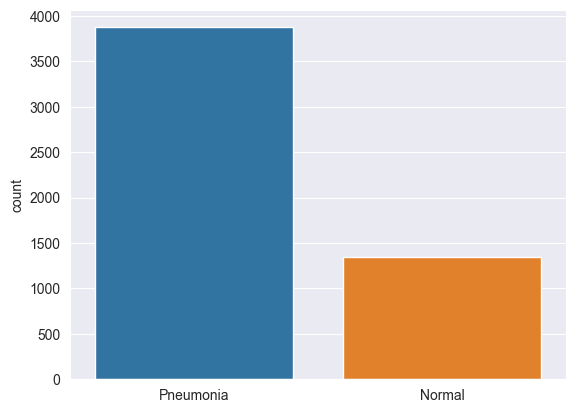

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

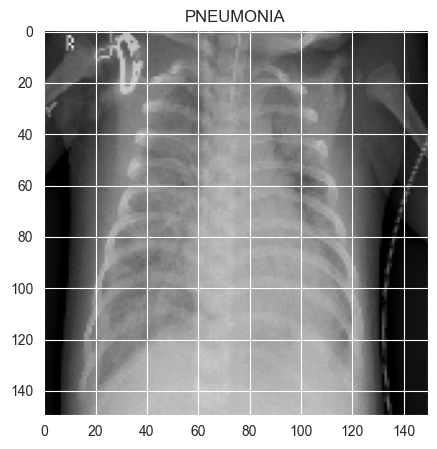

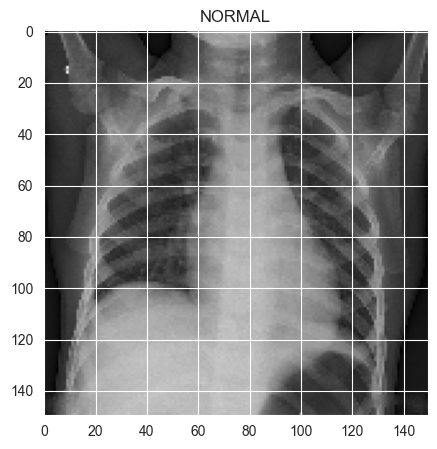

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [26]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#used for the resnet model
x_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_train))
x_val_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_val))
x_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_test))

def resnet_resize(image):
    return tf.image.resize(image,  [224, 224]).numpy() 

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, we choosed to:
1. Randomly rotate some training images by 60 degrees 
2. Randomly Zoom by 60% some training images
3. Randomly shift images horizontally by 50% of the width 
4. Randomly shift images vertically by 20% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Create model function

In [11]:
def create_model(learning_rate=0.001, dropout_rate=0.2, dropout_rate_conv=0.2, optimizer=None):
    
    if not optimizer:
        optimizer = Adam(learning_rate=learning_rate)
        
    model = Sequential()
    
    # First Conv Layer
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Second Conv Layer
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate_conv))  # Tunable dropout rate
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Third Conv Layer
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Fourth Conv Layer
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate_conv))  # Tunable dropout rate
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Fifth Conv Layer
    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate_conv))  # Tunable dropout rate
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Flatten Layer
    model.add(Flatten())
    
    # Fully Connected Dense Layer
    model.add(Dense(units=128, activation='relu'))  # Tunable units
    model.add(Dropout(dropout_rate))  # Tunable dropout rate
    
    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define the Hyperparameter Search Space

In [12]:
keras_clf = KerasClassifier(build_fn=create_model, epochs=12, batch_size=32, verbose=1)

# Define the hyperparameter search space
param_space = {
    'learning_rate': (1e-5, 1e-2, 'log-uniform'), 
    'dropout_rate': (0.05, 0.4),  
    'dropout_rate_conv': (0.1, 0.4) 
}

C:\Users\dsour\AppData\Local\Temp\ipykernel_27612\2719850882.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_fn=create_model, epochs=12, batch_size=32, verbose=1)


# Implement Bayesian Optimization Using BayesSearchCV

In [13]:

# Initialize BayesSearchCV
optimalized_model = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=2, 
    scoring='accuracy',
    cv=2,
    verbose=2,
    n_jobs=1
)
# Perform the optimization
optimalized_model.fit(x_train, y_train)

# Get the best hyperparameters
print("Best parameters found: ", optimalized_model.best_params_)
print("Best accuracy: ", optimalized_model.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/12
82/82 [==============================] - 43s 512ms/step - loss: 0.3476 - accuracy: 0.8562
Epoch 2/12
82/82 [==============================] - 42s 517ms/step - loss: 0.1601 - accuracy: 0.9417
Epoch 3/12
82/82 [==============================] - 43s 519ms/step - loss: 0.1386 - accuracy: 0.9448
Epoch 4/12
82/82 [==============================] - 43s 520ms/step - loss: 0.1003 - accuracy: 0.9628
Epoch 5/12
82/82 [==============================] - 43s 527ms/step - loss: 0.0857 - accuracy: 0.9678
Epoch 6/12
82/82 [==============================] - 43s 522ms/step - loss: 0.0762 - accuracy: 0.9686
Epoch 7/12
82/82 [==============================] - 43s 520ms/step - loss: 0.0756 - accuracy: 0.9709
Epoch 8/12
82/82 [==============================] - 42s 513ms/step - loss: 0.0659 - accuracy: 0.9781
Epoch 9/12
82/82 [==============================] - 42s 513ms/step - loss: 0.0639 - accuracy: 0.9785
Epoch 10/12
82/82 [=============

# Defining the Models

Defining best model from the bayesian optimalisation

In [14]:
dropout_rate = optimalized_model.best_params_['dropout_rate']
learning_rate = optimalized_model.best_params_['learning_rate']
dropout_rate_conv = optimalized_model.best_params_['dropout_rate_conv']

hpo_model = create_model(learning_rate, dropout_rate_conv, dropout_rate)


Defining the baseline model

In [15]:
baseline_model = create_model(dropout_rate=0.2, dropout_rate_conv=0.2, optimizer="rmsprop")


Defining the alternative model/technique ResNet50

In [16]:
# Load ResNet50 without top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base.layers:
    layer.trainable = False  

# Custom top layers similar to the CNN's dense block
x = resnet_base.output
x = Flatten()(x)  # Flatten like in the CNN
x = Dense(128, activation='relu')(x)  
x = Dropout(0.2)(x)  # Same dropout as baseline
x = BatchNormalization()(x)  
predictions = Dense(1, activation='sigmoid')(x)

# Define and compile model
resnet_model = Model(inputs=resnet_base.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Training the Models

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Fitting the baseline models with the training data

In [18]:
baseline_history = baseline_model.fit(
    datagen.flow(x_train,y_train, batch_size = 32),
    epochs = 12 , validation_data = datagen.flow(x_val, y_val),
    callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 95s 576ms/step - loss: 0.5920 - accuracy: 0.8225 - val_loss: 42.0636 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 94s 578ms/step - loss: 0.2954 - accuracy: 0.8859 - val_loss: 66.7394 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9130
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 93s 571ms/step - loss: 0.2304 - accuracy: 0.9130 - val_loss: 109.5691 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 91s 558ms/step - loss: 0.1671 - accuracy: 0.9375 - val_loss: 17.1336 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 91s 556ms/step - loss: 0.1557 - accuracy: 0.9467 - val_loss: 2.3047 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/12
163/163 [================

Fitting the model with bayesian optimalised hyper parameters with the training data

In [30]:
hpo_history = hpo_model.fit(
    datagen.flow(x_train,y_train, batch_size = 32),
    epochs = 12 , validation_data = datagen.flow(x_val, y_val),
    callbacks = [learning_rate_reduction])


Epoch 1/12
163/163 [==============================] - 90s 552ms/step - loss: 0.1737 - accuracy: 0.9306 - val_loss: 1.3741 - val_accuracy: 0.5625 - lr: 7.8618e-06
Epoch 2/12
163/163 [==============================] - 90s 550ms/step - loss: 0.1698 - accuracy: 0.9316 - val_loss: 1.4763 - val_accuracy: 0.5625 - lr: 7.8618e-06
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9331
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.358537949476158e-06.
163/163 [==============================] - 91s 557ms/step - loss: 0.1736 - accuracy: 0.9331 - val_loss: 1.3800 - val_accuracy: 0.5625 - lr: 7.8618e-06
Epoch 4/12
163/163 [==============================] - 90s 554ms/step - loss: 0.1719 - accuracy: 0.9360 - val_loss: 1.6266 - val_accuracy: 0.5000 - lr: 2.3585e-06
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9348
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-06.
163/163 [==========================

Fitting the alternative ResNet50 model with the training data

In [20]:
resnet_history = resnet_model.fit(
    datagen.flow(
        resnet_resize(x_train_rgb), 
        y_train,
        batch_size=32),
    epochs=12,
    validation_data=datagen.flow(
                                resnet_resize(x_val_rgb),
                                y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/12
163/163 [==============================] - 217s 1s/step - loss: 0.5980 - accuracy: 0.7046 - val_loss: 0.7159 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/12
163/163 [==============================] - 222s 1s/step - loss: 0.5214 - accuracy: 0.8138 - val_loss: 0.7598 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8207
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 [==============================] - 221s 1s/step - loss: 0.4857 - accuracy: 0.8207 - val_loss: 0.7623 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/12
163/163 [==============================] - 223s 1s/step - loss: 0.4364 - accuracy: 0.8322 - val_loss: 0.8131 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 5/12
163/163 [==============================] - 225s 1s/step - loss: 0.4233 - accuracy: 0.8334 - val_loss: 0.6675 - val_accuracy: 0.6250 - lr: 3.0000e-05
Epoch 6/12
163/163 [==================

# Evaluation the models

Evaluation the baseline model

In [21]:
print("Loss of the model is - " , baseline_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , baseline_model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 122ms/step - loss: 0.5566 - accuracy: 0.8974
Loss of the model is -  0.5565913915634155
20/20 [==============================] - 2s 121ms/step - loss: 0.5566 - accuracy: 0.8974
Accuracy of the model is -  89.74359035491943 %


Evaluation the bayesian optimalised hyper parameter model

In [32]:
print("Loss of the model is - " , hpo_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , hpo_model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 136ms/step - loss: 0.3149 - accuracy: 0.8910
Loss of the model is -  0.31485700607299805
20/20 [==============================] - 3s 132ms/step - loss: 0.3149 - accuracy: 0.8910
Accuracy of the model is -  89.10256624221802 %


Evaluation the ResNet50 model

In [27]:
print("Loss of the model is - " , resnet_model.evaluate(resnet_resize(x_test_rgb),y_test)[0])
print("Accuracy of the model is - " , resnet_model.evaluate(resnet_resize(x_test_rgb),y_test)[1]*100 , "%")

20/20 [==============================] - 24s 1s/step - loss: 0.4519 - accuracy: 0.8125
Loss of the model is -  0.45191216468811035
20/20 [==============================] - 25s 1s/step - loss: 0.4519 - accuracy: 0.8125
Accuracy of the model is -  81.25 %


# Analysis after Model Training

Create analysis function

In [28]:
def plot_history(history, title_prefix="Model"):
    epochs = [i for i in range(len(history.history['accuracy']))]
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title(f'{title_prefix} - Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
    ax[1].set_title(f'{title_prefix} - Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

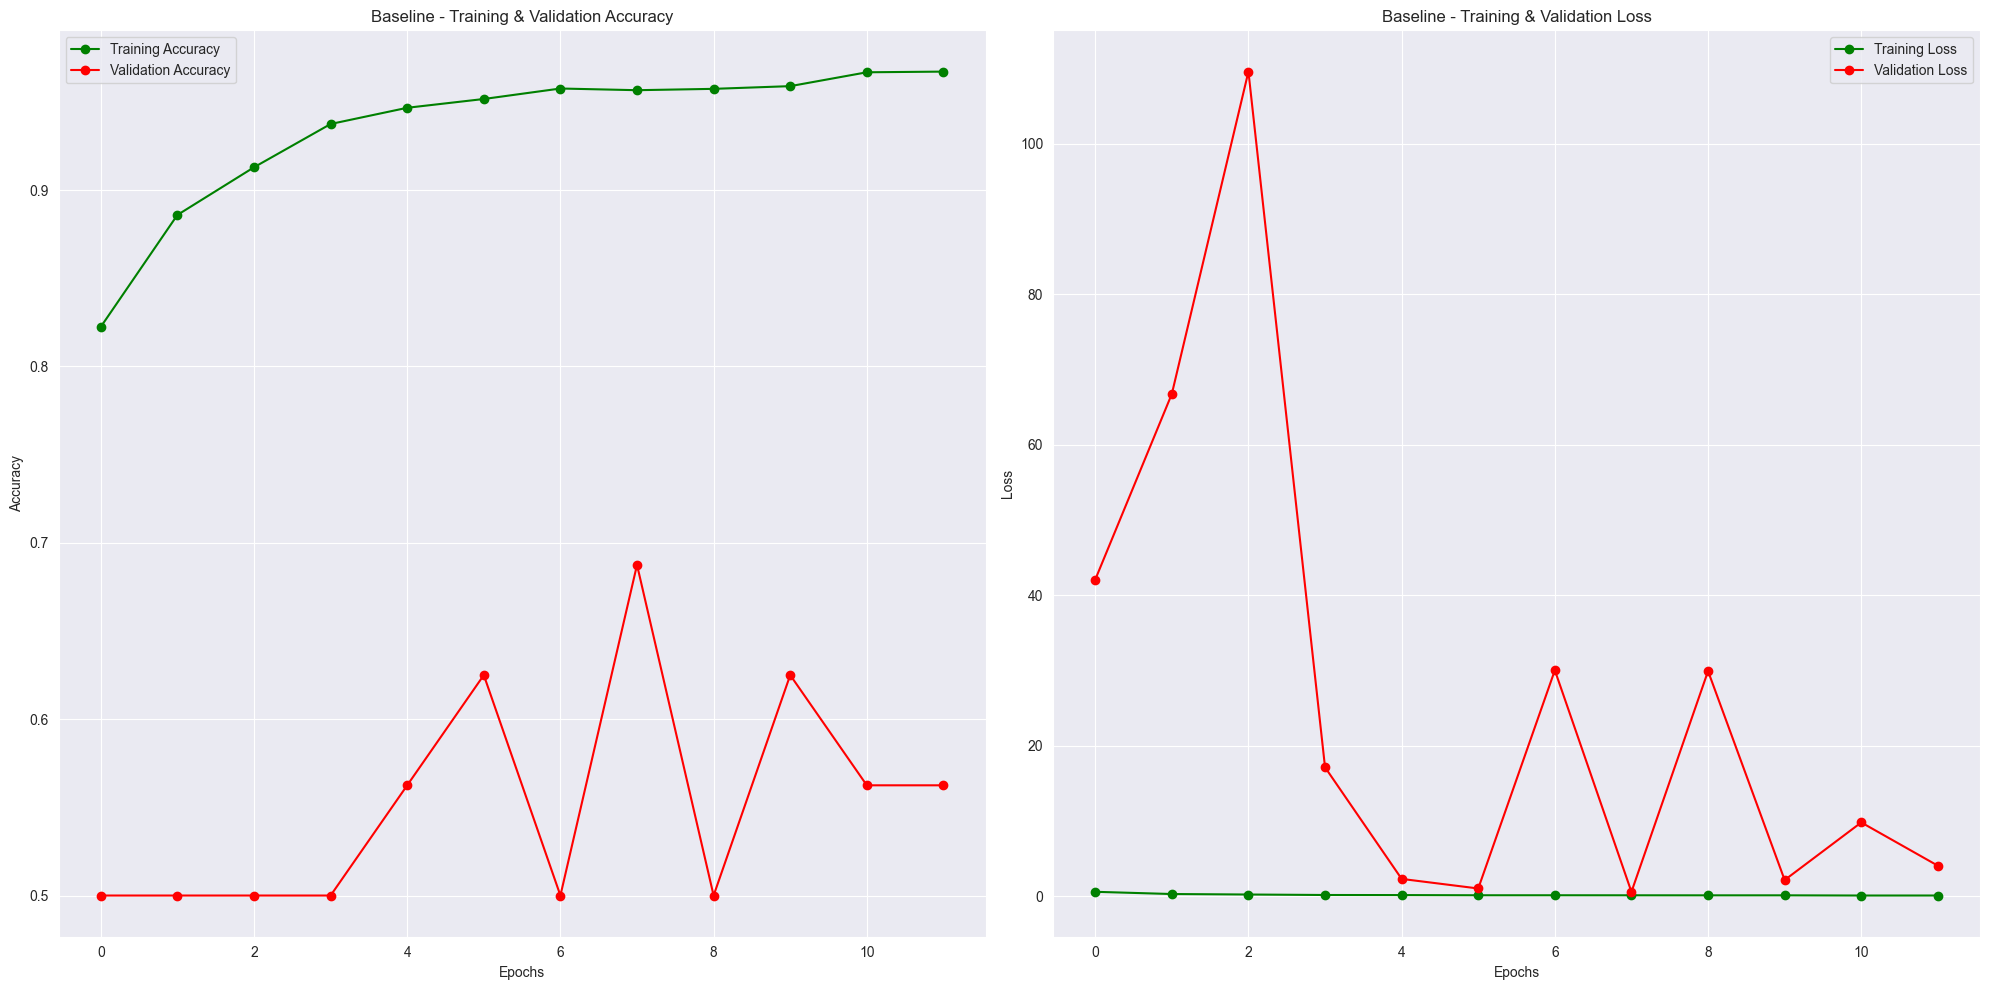

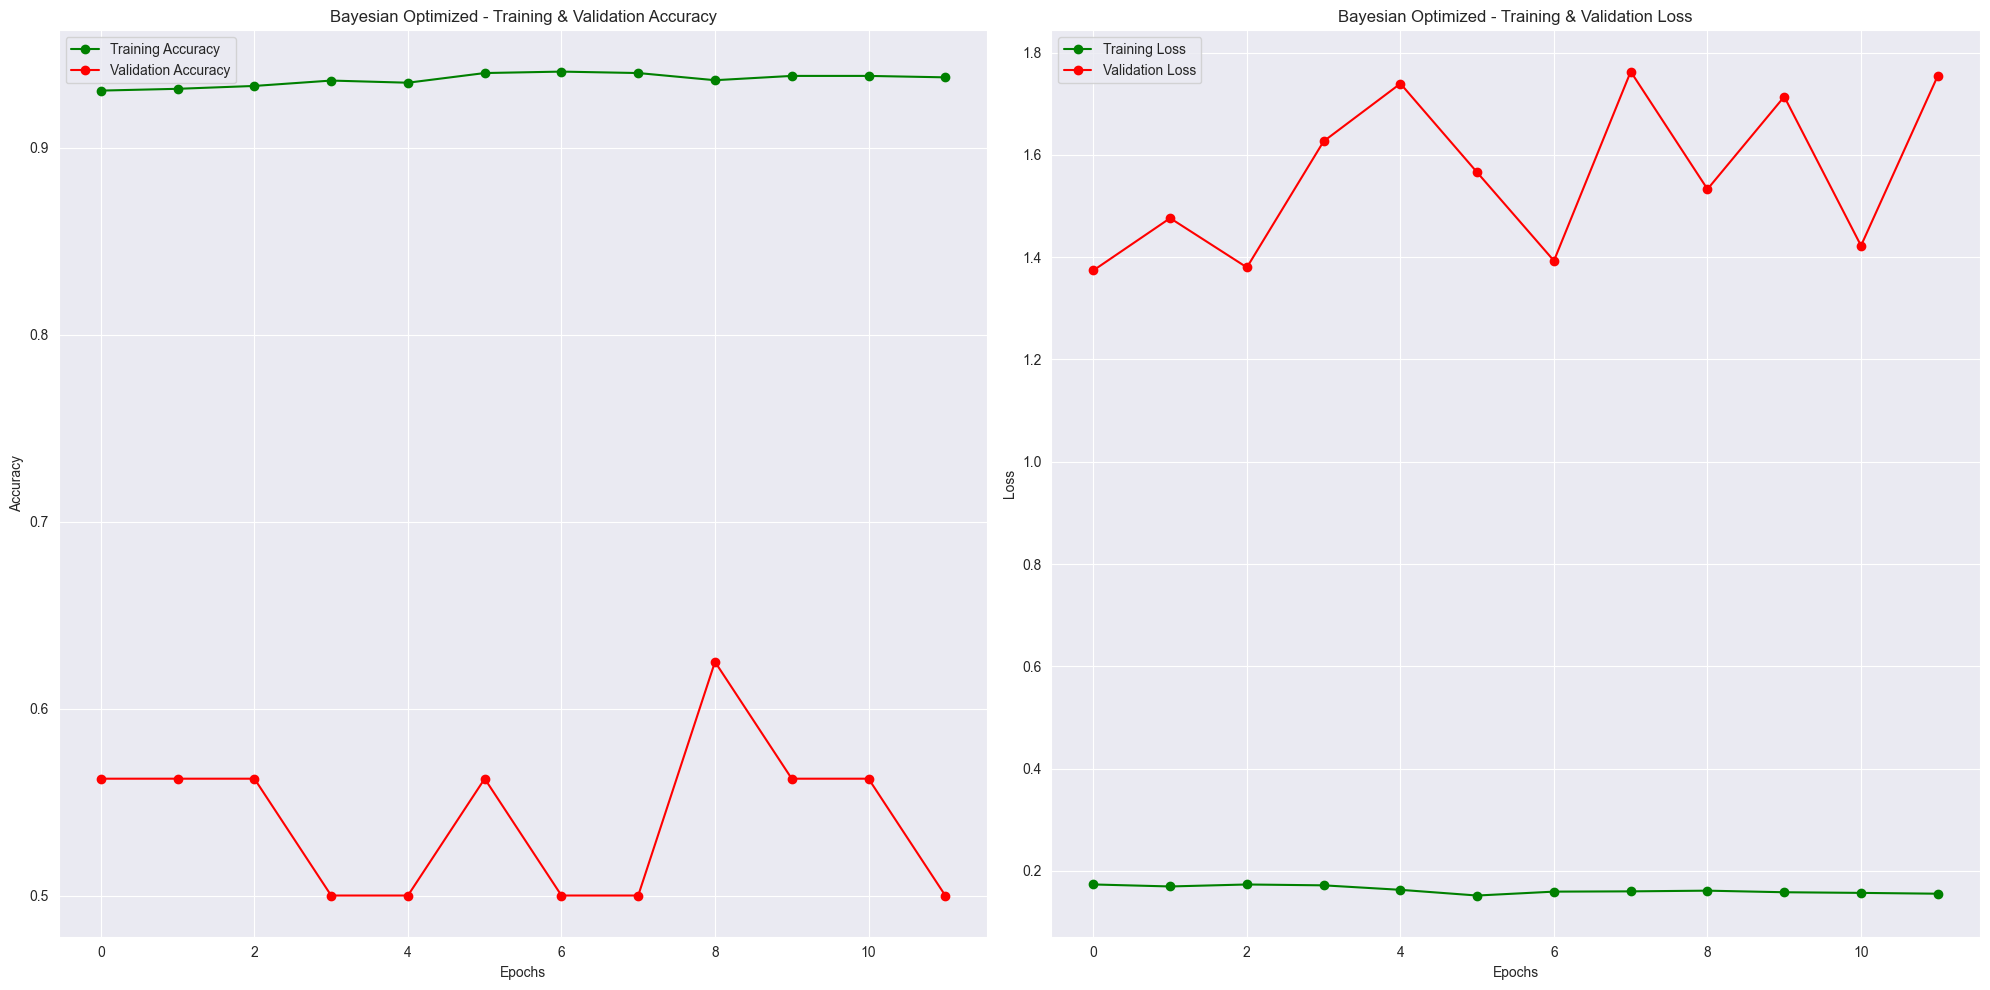

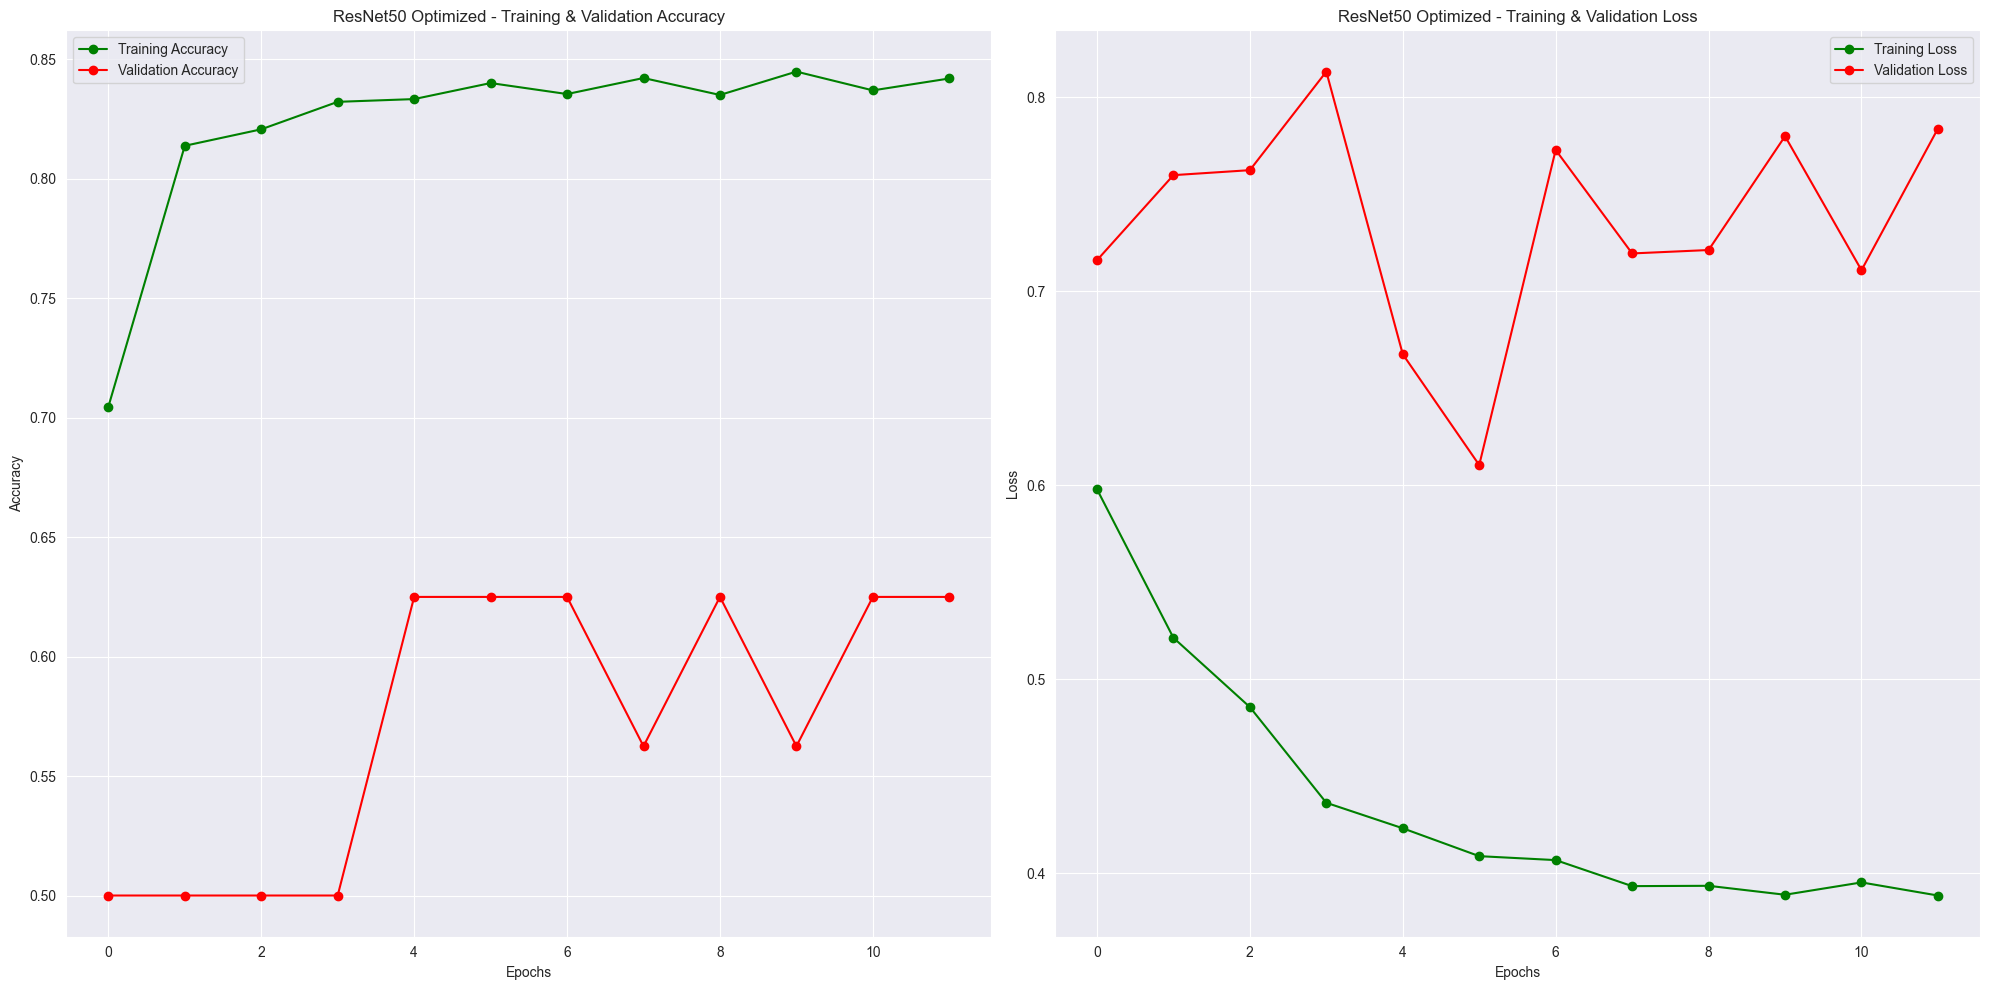

In [33]:
plot_history(baseline_history, title_prefix="Baseline")
plot_history(hpo_history, title_prefix="Bayesian Optimized")
plot_history(resnet_history, title_prefix="ResNet50 Optimized")

In [ ]:
baseline_predictions = baseline_model.predict(x_test)
baseline_predicted_classes = (baseline_predictions > 0.5).astype("int32")


hpo_predictions = hpo_model.predict(x_test)
hpo_predicted_classes = (hpo_predictions > 0.5).astype("int32")

resnet_predictions = resnet_model.predict(resnet_resize(x_test_rgb))
resnet_predicted_classes = (resnet_predictions > 0.5).astype("int32")


baseline_predicted_classes[:15]
hpo_predicted_classes[:15]
resnet_predicted_classes[:15]


20/20 [==============================] - 2s 122ms/step


ValueError: in user code:

    File "c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\dsour\assignment-2-xai\venv\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model" "                 f"(type Functional).
    
    Input 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 230, 230, 1)
    
    Call arguments received by layer "model" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
      • training=False
      • mask=None


In [ ]:
print(classification_report(y_test, baseline_predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))
print(classification_report(y_test, hpo_predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))
print(classification_report(y_test, resnet_predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.92      0.92       390
   Normal (Class 1)       0.87      0.88      0.87       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.96      0.93       390
   Normal (Class 1)       0.93      0.82      0.87       234

           accuracy                           0.91       624
          macro avg       0.91      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [ ]:
baseline_cm = confusion_matrix(y_test, baseline_predicted_classes)
hpo_cm = confusion_matrix(y_test, hpo_predicted_classes)
resnet_cm = confusion_matrix(y_test, resnet_predicted_classes)

baseline_cm, hpo_cm, resnet_cm

(array([[360,  30],
        [ 29, 205]], dtype=int64),
 array([[375,  15],
        [ 42, 192]], dtype=int64))

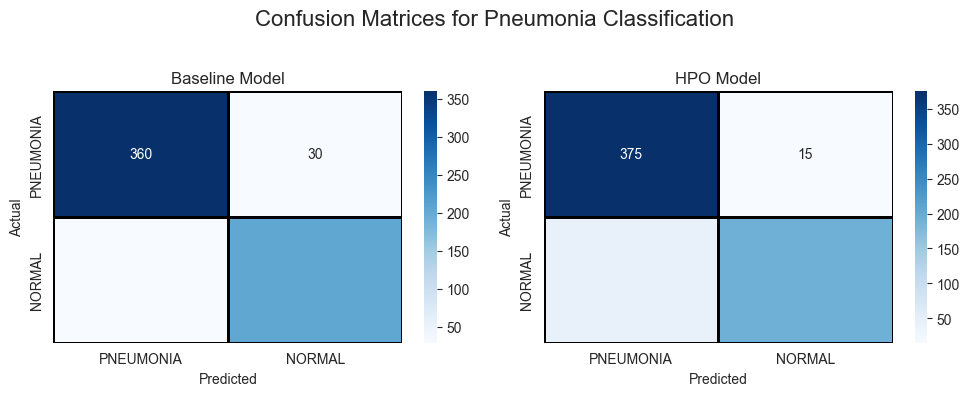

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4)) 

# Baseline Confusion Matrix
baseline_cm_df = pd.DataFrame(baseline_cm, index=labels, columns=labels)
sns.heatmap(baseline_cm_df, cmap="Blues", linecolor='black', linewidth=1,
            annot=True, fmt='d', ax=axes[0])
axes[0].set_title("Baseline Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# HPO Confusion Matrix
hpo_cm_df = pd.DataFrame(hpo_cm, index=labels, columns=labels)
sns.heatmap(hpo_cm_df, cmap="Blues", linecolor='black', linewidth=1,
            annot=True, fmt='d', ax=axes[1])
axes[1].set_title("HPO Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# ResNet Confusion Matrix
resnet_cm_df = pd.DataFrame(resnet_cm, index=labels, columns=labels)
sns.heatmap(resnet_cm_df, cmap="Blues", linecolor='black', linewidth=1,
            annot=True, fmt='d', ax=axes[2])
axes[2].set_title("ResNet Model")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

# Plot title
plt.suptitle("Confusion Matrices for Pneumonia Classification", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- There is a bug in the Seaborn library version being used (`0.12.0`), which causes only the top value to be filled in.  
- Unfortunately, the Seaborn library can't be updated since it conflicts with other dependencies.  
- So there is no quick fix for this — only creating the plot in a separate file using the up-to-date Seaborn library.  
- Run `pip install seaborn --upgrade` in a different environment to create a proper plot.


In [ ]:
correct = np.nonzero(baseline_predictions == y_test)[0]
incorrect = np.nonzero(baseline_predictions != y_test)[0]

hpo_correct = np.nonzero(hpo_predictions == y_test)[0]
hpo_incorrect = np.nonzero(hpo_predictions != y_test)[0]

resnet_correct = np.nonzero(resnet_predictions == y_test)[0]
resnet_incorrect = np.nonzero(resnet_predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

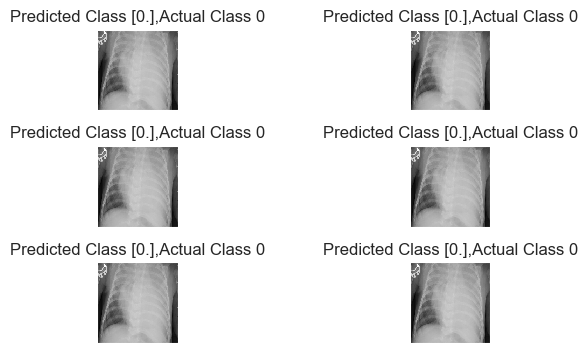

In [29]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(baseline_predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

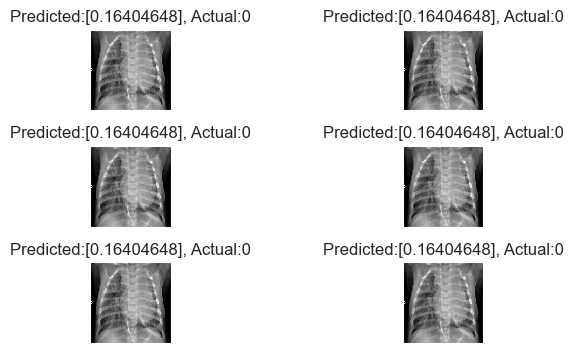

In [30]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted:{}, Actual:{}".format(baseline_predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Introducing functions for the heatmap

In [31]:
preprocess_input = keras.applications.xception.preprocess_input

In [38]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = int(tf.argmax(preds[0]))
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


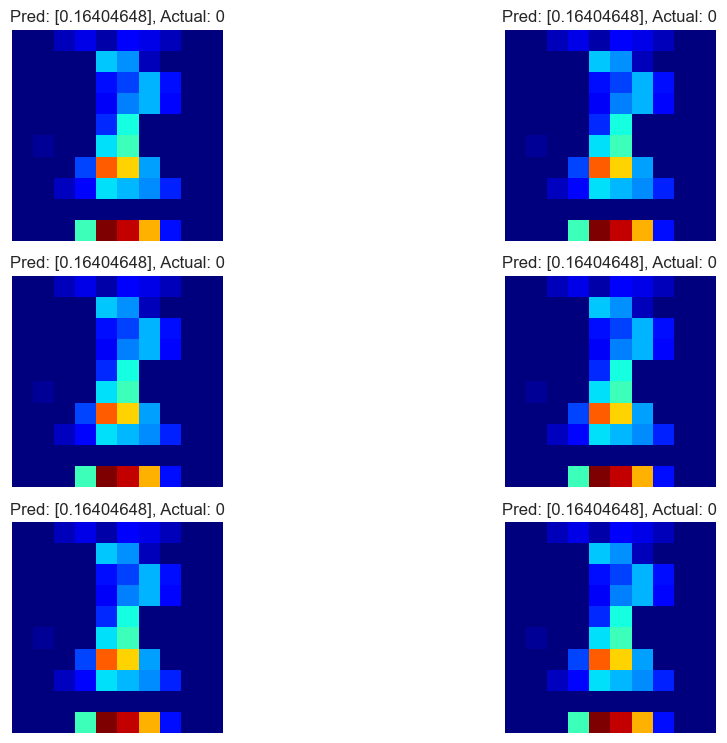

In [40]:
plt.figure(figsize=(10, 10))

for i, c in enumerate(incorrect[:6]):
    img_array = np.expand_dims(x_test[c], axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, baseline_model)

    # Plot the heatmap in a subplot
    plt.subplot(4, 2, i + 1)
    plt.imshow(heatmap, cmap='jet')  # 'jet' colormap makes it more vivid
    plt.axis("off")
    plt.title(f"Pred: {baseline_predictions[c]}, Actual: {y_test[c]}")

plt.tight_layout()
plt.show()


In [41]:
def display_gradcam(img_array, heatmap, alpha=0.4, subplot=False):
    """
    Displays or plots the Grad-CAM heatmap superimposed on the input image array.

    Parameters:
        img_array: numpy array of shape (1, H, W, 3)
        heatmap: 2D array of shape (H, W), values between 0 and 1
        alpha: blending factor for heatmap overlay
        subplot: if True, does not call plt.show() (used in subplot grids)
    """
    img = img_array[0]
    img = (img - img.min()) / (img.max() - img.min())
    img = np.uint8(255 * img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")
    if not subplot:
        plt.title("Grad-CAM")
        plt.show()


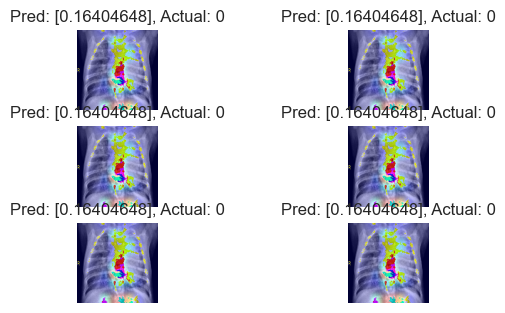

In [43]:
i = 0
for c in incorrect[:6]:
    img_array = np.expand_dims(x_test[c], axis=0)
    
    heatmap = make_gradcam_heatmap(img_array, baseline_model)

    plt.subplot(4, 2, i + 1)
    display_gradcam(img_array, heatmap, subplot=True)
    plt.title("Pred: {}, Actual: {}".format(baseline_predictions[c], y_test[c]))
    i += 1
    
plt.show()
